# Import Libiraries

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import pickle
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_19564/4110962823.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [6]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Trotter Gate

In [7]:
def trotter_gate(dt, to_instruction = True):
    qc = QuantumCircuit(2)
    qc.rx(2*dt,0)
    qc.rz(2*dt,1)
    qc.h(1)
    qc.cx(1,0)
    qc.rz(-2*dt, 0)
    qc.rx(-2*dt, 1)
    qc.rz(2*dt, 1)
    qc.cx(1,0)
    qc.h(1)
    qc.rz(2*dt, 0)
    return qc.to_instruction() if to_instruction else qc

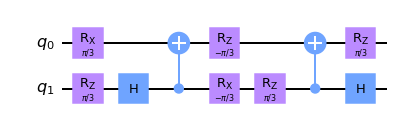

In [8]:
trotter_gate(np.pi / 6, to_instruction=False).draw("mpl")

# Set Parameters

In [9]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')
# Convert custom quantum circuit into a gate
Trot_gate = trotter_gate(dt)

# Number of trotter steps
trotter_steps = 100  ### CAN BE >= 4

# Make Quantum Circuit

- logical → physical
- 0       → 5
- 1       → 3
- 2       → 1

In [10]:
# Initialize quantum circuit for 3 qubits
# qr = QuantumRegister(7)
qc = QuantumCircuit(3)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([1,0])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

qc.x([1]) # encoding

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [1, 0])

qc.cx(1, 2)
qc.cx(0, 1)

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({dt: target_time/trotter_steps})

In [11]:
# circuit optimization
t3_qc = transpile(qc, optimization_level=3, basis_gates=["sx", "cx", "rz"])
t3_qc = transpile(t3_qc, optimization_level=3, basis_gates=["sx", "cx", "rz"])

In [12]:
# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(t3_qc, [2, 1, 0])

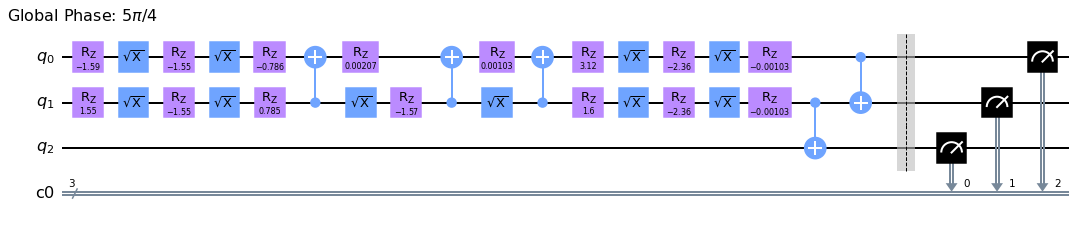

In [13]:
# Display circuit for confirmation
# st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
st_qcs[-1].draw("mpl")  # only view trotter gates

In [14]:
# Pauli Twirling
def pauli_twirling(circ: str) -> QuantumCircuit:
    """
    そのまま使う: 修正は後回し
    """
    #! qasm ベタ書き
    def apply_pauli(num: int, qb: int) -> str:
        if (num == 0):
            return f'id q[{qb}];\n'
        elif (num == 1):
            return f'x q[{qb}];\n'
        elif (num == 2):
            return f'y q[{qb}];\n'
        else:
            return f'z q[{qb}];\n'

    paulis = [(i,j) for i in range(0,4) for j in range(0,4)]
    paulis.remove((0,0))
    paulis_map = [(0, 1), (3, 2), (3, 3), (1, 1), (1, 0), (2, 3), (2, 2), (2, 1), (2, 0), (1, 3), (1, 2), (3, 0), (3, 1), (0, 2), (0, 3)]

    new_circ = ''
    ops = circ.qasm().splitlines(True) #! 生のqasmコードを持ってきてる: オペレータに分解
    for op in ops:
        if (op[:2] == 'cx'): # can add for cz, etc.
            num = random.randrange(len(paulis)) #! permute paulis
            qbs = re.findall('q\[(.)\]', op)
            new_circ += apply_pauli(paulis[num][0], qbs[0])
            new_circ += apply_pauli(paulis[num][1], qbs[1])
            new_circ += op
            new_circ += apply_pauli(paulis_map[num][0], qbs[0])
            new_circ += apply_pauli(paulis_map[num][1], qbs[1])
        else:
            new_circ += op
    return QuantumCircuit.from_qasm_str(new_circ)

In [15]:
def zne_wrapper(qcs, scale_factors = [1.0, 2.0, 3.0]):
    """
    """
    folded_qcs = [] #! ZNE用の回路
    for qc in qcs:
        folded_qcs.append([mitiq.zne.scaling.fold_gates_at_random(qc, scale) for scale in scale_factors]) #! ここでmitiqを使用
    folded_qcs = list(itertools.chain(*folded_qcs)) #! folded_qcsを平坦化
    folded_qcs = [pauli_twirling(circ) for circ in folded_qcs] #! 後からPauli Twirlingを施す!
    return folded_qcs

In [16]:
zne_qcs = zne_wrapper(st_qcs)
print("number of circuits: ", len(zne_qcs))

number of circuits:  81


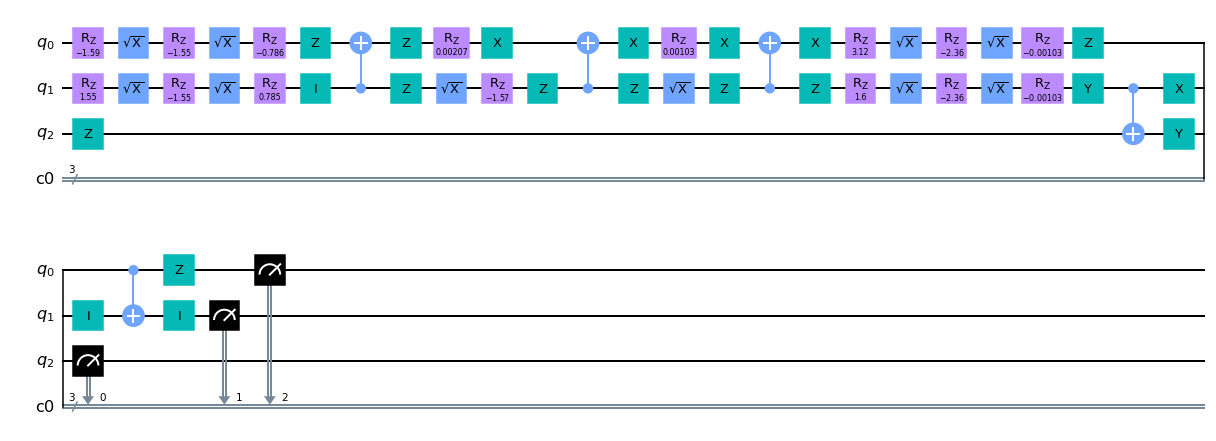

In [17]:
zne_qcs[-3].draw("mpl")

In [20]:
zne_qcs_jakarta = transpile(zne_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"], initial_layout=[5,3,1])
zne_qcs_jakarta = transpile(zne_qcs_jakarta, optimization_level=3, basis_gates=["sx", "cx", "rz"])

QiskitError: "Cannot unroll the circuit to the given basis, ['sx', 'cx', 'rz']. Instruction id not found in equivalence library and no rule found to expand."

# Set Backend

In [18]:
from qiskit.test.mock import FakeJakarta
backend = FakeJakarta()
# backend = Aer.get_backend("qasm_simulator")

# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
# provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
# print("provider:", provider)
# backend = provider.get_backend("ibmq_jakarta")

# Set Execute Options

In [19]:
shots = 8192
reps = 8

In [15]:
jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 6250747b73968ca0fa07bfe7
Job ID 6250747d73968c55b007bfe8
Job ID 6250747f4b515249b07c7888
Job ID 62507481fdf3772d0656ff9c
Job ID 6250748473968cf82107bfe9
Job ID 625074864b51523ba97c7889
Job ID 62507488fdf377604156ff9f
Job ID 6250748af65d786946391011


# QREM

In [16]:
# QREM
qr = QuantumRegister(num_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
cal_job = execute(meas_calibs, backend=backend, shots=shots, optimization_level=3)
print('Job ID', cal_job.job_id())

Job ID 6250748ffdf3775e6756ffa2


In [17]:
with open("jakarta_100step.pkl", "wb") as f:
    pickle.dump({"jobs": jobs, "cal_job": cal_job}, f)

# ====== wait for the job ======

In [17]:
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
mit_results = []
for job in jobs:
    mit_results.append( meas_fitter.filter.apply(job.result()) )

# State Tomography

In [18]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute Fidelity

In [19]:
# Compute tomography fidelities for each repetition
fids = []
for result in mit_results:
    fid = state_tomo(result, st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.9008 ± 0.0022
